# CIFAR-10 图像分类实验

本notebook实现了在CIFAR-10数据集上的深度学习图像分类实验，包含多种CNN架构和训练策略的比较。

## 实验内容
- 基础CNN模型
- ResNet残差连接
- 不同层数和隐藏层维度
- 不同池化方式（最大池化/平均池化）
- SGD和Adam优化器
- L2正则化
- 数据增强


In [ ]:
!pip install torch
!pip install torchvision
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install scikit-learn

Looking in indexes: https://mirrors.cloud.tencent.com/pypi/simple
  Using cached https://mirrors.cloud.tencent.com/pypi/packages/58/1d/fd1e88ae0948825efcab7dd66d12bec23f05d4d38ed81573c8d453c14c06/torch-2.9.0-cp310-cp310-manylinux_2_28_x86_64.whl (899.8 MB)
  Using cached https://mirrors.cloud.tencent.com/pypi/packages/76/91/7216b27286936c16f5b4d0c530087e4a54eead683e6b0b73dd0c64844af6/filelock-3.20.0-py3-none-any.whl (16 kB)
  Using cached https://mirrors.cloud.tencent.com/pypi/packages/a2/09/77d55d46fd61b4a135c444fc97158ef34a095e5681d0a6c10b75bf356191/sympy-1.14.0-py3-none-any.whl (6.3 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 56.7 MB/s  0:00:00
  Using cached https://mirrors.cloud.tencent.com/pypi/packages/62/a1/3d680cbfd5f4b8f15abc1d571870c5fc3e594bb582bc3b64ea099db13e56/jinja2-3.1.6-py3-none-any.whl (134 kB)
  Using cached https://mirrors.cloud.tencent.com/pypi/packages/47/71/70db47e4f6ce3e5c37a607355f80da8860a33226be640226ac52cb05ef2e/fsspec-2025.9.0-py3-none-any

In [ ]:
# 导入必要的库
import torch
import torchvision
import os
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import time
import argparse
from model_utils import *


## 数据加载和预处理


In [42]:
# 设置随机种子
torch.manual_seed(42)
np.random.seed(42)
work_dir = '/llmchat/daixunlian/workspace'
# 数据预处理
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

print("加载CIFAR-10数据集...")

# 加载数据集
train_dataset = datasets.CIFAR10(root=os.path.join(work_dir, 'class_project/deep_learning/hw_1/dataset/cifar'), 
                                 train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root=os.path.join(work_dir, 'class_project/deep_learning/hw_1/dataset/cifar'), 
                                train=False, download=True, transform=transform)

# 创建数据加载器
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False, num_workers=2)

# CIFAR-10类别名称
classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

print(f"训练集大小: {len(train_dataset)}")
print(f"测试集大小: {len(test_dataset)}")
print(f"类别数量: {len(classes)}")


加载CIFAR-10数据集...
训练集大小: 50000
测试集大小: 10000
类别数量: 10


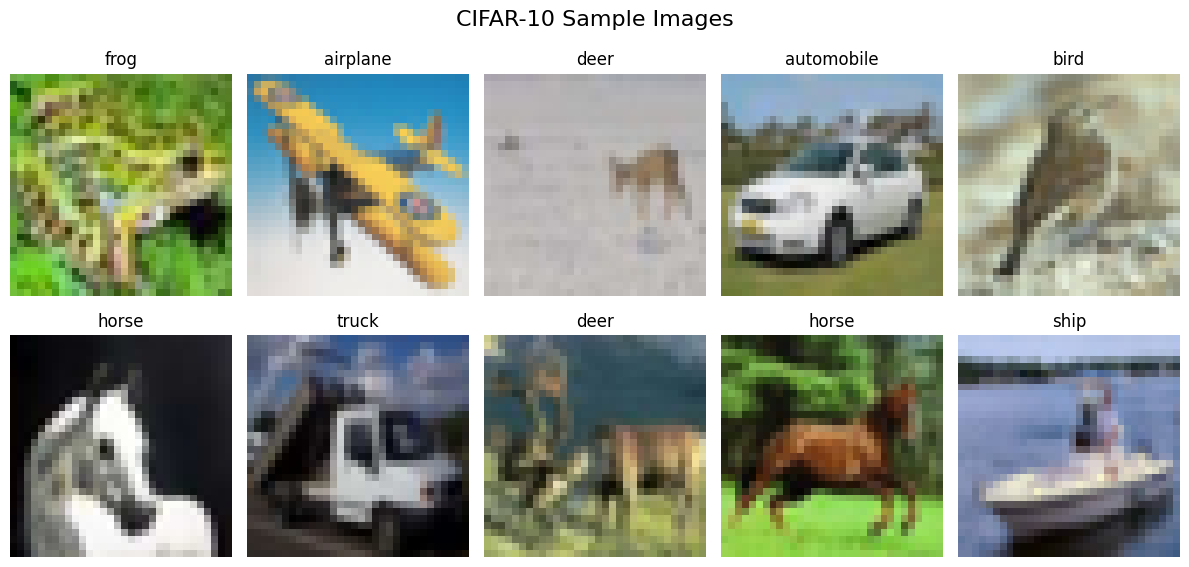

样本图像已保存到 cifar10_samples.png


In [43]:
# 展示样本图像
def show_sample(train_loader):
    """展示10个样本"""
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
                   'dog', 'frog', 'horse', 'ship', 'truck']
    data_iter = iter(train_loader)
    images, labels = next(data_iter)

    plt.figure(figsize=(12, 6))
    for i in range(10):
        img = (images[i] * 0.5 + 0.5)  # 反归一化
        img = img.permute(1, 2, 0).numpy()  # CHW -> HWC

        plt.subplot(2, 5, i+1)
        plt.imshow(img)
        plt.title(class_names[labels[i].item()])
        plt.axis('off')

    plt.suptitle("CIFAR-10 Sample Images", fontsize=16)
    plt.tight_layout()
    plt.savefig('./outputs/cifar/cifar10_samples.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("样本图像已保存到 cifar10_samples.png")

# 展示样本
show_sample(train_loader)


## 训练和评估函数


In [44]:
# 训练函数 - 添加早停机制
def train(model, train_loader, test_loader, criterion, optimizer, 
          epochs, device, save_dir, is_l2_loss=False, l2_lambda=0.001,
          config_name="base", patience=10):
    """
    训练函数，支持早停机制
    
    Args:
        patience: 早停的耐心值，如果连续patience个epoch准确率没有提升则停止训练
    """
    model.train()
    
    # 记录训练历史
    train_losses = []
    test_accuracies = []
    best_acc = 0.0
    best_epoch = 0
    epochs_no_improve = 0  # 记录连续多少个epoch没有提升
    
    print(f"\n{'='*60}")
    print(f"训练配置: {config_name}")
    print(f"L2正则化: {'是 (λ=' + str(l2_lambda) + ')' if is_l2_loss else '否'}")
    print(f"早停机制: 启用 (patience={patience})")
    print(f"{'='*60}\n")
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            
            if is_l2_loss:
                l2_reg = torch.tensor(0., device=device)
                for param in model.parameters():
                    l2_reg += torch.norm(param, 2)
                loss += l2_lambda * l2_reg
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            if batch_idx % 100 == 99:
                avg_loss = running_loss / 100
                train_acc = 100 * correct / total
                print(f'Epoch: {epoch+1}/{epochs} | '
                      f'Batch: {batch_idx+1}/{len(train_loader)} | '
                      f'Loss: {avg_loss:.4f} | '
                      f'Train Acc: {train_acc:.2f}%')
                running_loss = 0.0

        # 评估模型
        test_acc = evaluate(model, test_loader, device)
        test_accuracies.append(test_acc)
        
        print(f'\nEpoch {epoch+1} 完成 - 测试准确率: {test_acc:.2f}%')
        
        # 检查是否有提升
        if test_acc > best_acc:
            best_acc = test_acc
            best_epoch = epoch
            epochs_no_improve = 0  # 重置计数器
            
            # 保存最佳模型
            save_path = os.path.join(save_dir, f'best_{config_name}.pth')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'accuracy': test_acc,
            }, save_path)
            print(f'✓ 最佳模型已保存，准确率: {test_acc:.2f}%')
        else:
            epochs_no_improve += 1
            print(f'准确率未提升 ({epochs_no_improve}/{patience})')
            
            # 早停检查
            if epochs_no_improve >= patience and epoch >= 100:
                print(f'\n{"="*60}')
                print(f'早停触发！连续{patience}个epoch准确率未提升')
                print(f'最佳准确率: {best_acc:.2f}% (Epoch {best_epoch+1})')
                print(f'{"="*60}\n')
                break
        
        print()  # 空行分隔

        # 定期保存检查点
        if (epoch + 1) % 10 == 0:
            save_path = os.path.join(save_dir, f'{config_name}_epoch{epoch+1}.pth')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'accuracy': test_acc,
            }, save_path)
            print(f'检查点已保存: epoch {epoch+1}')
    
    # 训练结束总结
    print(f'\n{"="*60}')
    print(f'训练完成！')
    print(f'最终epoch: {epoch+1}')
    print(f'最佳准确率: {best_acc:.2f}% (Epoch {best_epoch+1})')
    print(f'{"="*60}\n')
    
    return test_accuracies, best_acc


def evaluate(model, test_loader, device):
    """评估模型"""
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy


def detailed_test(model, test_loader, device, classes, save_path=None):
    """
    详细测试函数 - 支持加载最佳模型
    
    Args:
        model: 模型实例
        test_loader: 测试数据加载器
        device: 设备
        classes: 类别名称列表
        save_path: 最佳模型保存路径，如果提供则先加载模型
    """
    
    # 如果提供了save_path，先加载最佳模型
    if save_path is not None:
        print(f"\n{'='*60}")
        print(f"加载最佳模型: {save_path}")
        print(f"{'='*60}")
        
        if os.path.exists(save_path):
            checkpoint = torch.load(save_path, map_location=device)
            model.load_state_dict(checkpoint['model_state_dict'])
            saved_acc = checkpoint.get('accuracy', 'N/A')
            saved_epoch = checkpoint.get('epoch', 'N/A')
            print(f"✓ 模型加载成功")
            print(f"  - 训练epoch: {saved_epoch + 1 if isinstance(saved_epoch, int) else saved_epoch}")
            print(f"  - 保存时准确率: {saved_acc if isinstance(saved_acc, str) else f'{saved_acc:.2f}%'}")
            print(f"{'='*60}\n")
        else:
            print(f"⚠ 警告: 模型文件不存在，使用当前模型状态")
            print(f"{'='*60}\n")
    
    # 开始详细测试
    model.eval()
    class_correct = [0] * 10
    class_total = [0] * 10
    y_trues, y_preds = [], []
    
    print("正在进行详细测试...")
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            y_preds.extend(predicted.cpu().numpy())
            y_trues.extend(labels.cpu().numpy())
            
            c = (predicted == labels)
            for i in range(len(labels)):
                label = labels[i].item()
                class_correct[label] += c[i].item()
                class_total[label] += 1
    
    print("\n" + "="*50)
    print("各类别准确率:")
    print("="*50)
    for i in range(10):
        if class_total[i] > 0:
            acc = 100 * class_correct[i] / class_total[i]
            print(f'{classes[i]:12s}: {acc:5.2f}% ({class_correct[i]}/{class_total[i]})')

    overall_acc = 100 * sum(class_correct) / sum(class_total)
    print(f'\n总体准确率: {overall_acc:.2f}%')
    
    print("\n" + "="*50)
    print("分类报告:")
    print("="*50)
    print(classification_report(y_trues, y_preds, target_names=classes))
    
    return y_trues, y_preds, overall_acc

In [45]:
# 可视化函数
def plot_confusion_matrix(y_trues, y_preds, classes, save_path):
    cm = confusion_matrix(y_trues, y_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    
    fig, ax = plt.subplots(figsize=(10, 10))
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    plt.xticks(rotation=45, ha='right')
    plt.title("Confusion Matrix", fontsize=14)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"混淆矩阵已保存到 {save_path}")

def plot_training_history(history_dict, save_path):
    plt.figure(figsize=(12, 6))
    
    for config_name, accuracies in history_dict.items():
        epochs = range(1, len(accuracies) + 1)
        plt.plot(epochs, accuracies, marker='o', label=config_name, linewidth=2)
    
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Test Accuracy (%)', fontsize=12)
    plt.title('Comparasion', fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"训练历史图已保存到 {save_path}")


## 实验配置和运行


In [47]:
# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

# 创建输出目录
save_dir = './outputs/cifar/checkpoints'
os.makedirs(save_dir, exist_ok=True)

# 实验参数
num_epochs = 200
learning_rate = 0.001

# 实验配置列表
experiments = [
    {"name": "base_experiment", "args": {}},
    {"name": "add_hidden_dim", "args": {"is_large_hidden": True}},
    {"name": "add_layer_num", "args": {"is_large_layer": True}},
    {"name": "use_mean_pooling", "args": {"mean_pooling": True}},
    {"name": "use_resnet", "args": {"is_resnet": True}},
    {"name": "use_l2_regular", "args": {"is_l2_loss": True}},
    {"name": "use_adam", "args": {"use_adam": True}},
]

print(f"将运行 {len(experiments)} 个实验")


使用设备: cuda
将运行 7 个实验



############################################################
# 实验 1/7: base_experiment
############################################################

训练配置: base_experiment
L2正则化: 否
早停机制: 启用 (patience=10)



Epoch: 1/200 | Batch: 100/782 | Loss: 2.3045 | Train Acc: 10.20%
Epoch: 1/200 | Batch: 200/782 | Loss: 2.3033 | Train Acc: 9.98%
Epoch: 1/200 | Batch: 300/782 | Loss: 2.3043 | Train Acc: 9.90%
Epoch: 1/200 | Batch: 400/782 | Loss: 2.3032 | Train Acc: 10.01%
Epoch: 1/200 | Batch: 500/782 | Loss: 2.3031 | Train Acc: 9.97%
Epoch: 1/200 | Batch: 600/782 | Loss: 2.3037 | Train Acc: 9.95%
Epoch: 1/200 | Batch: 700/782 | Loss: 2.3027 | Train Acc: 9.94%

Epoch 1 完成 - 测试准确率: 10.00%
✓ 最佳模型已保存，准确率: 10.00%

Epoch: 2/200 | Batch: 100/782 | Loss: 2.3037 | Train Acc: 9.67%
Epoch: 2/200 | Batch: 200/782 | Loss: 2.3027 | Train Acc: 9.79%
Epoch: 2/200 | Batch: 300/782 | Loss: 2.3029 | Train Acc: 9.92%
Epoch: 2/200 | Batch: 400/782 | Loss: 2.3028 | Train Acc: 9.81%
Epoch: 2/200 | Batch: 500/782 | Loss: 2.3027 | Train Acc: 9.81%
Epoch: 2/200 | Batch: 600/782 | Loss: 2.3027 | Train Acc: 9.85%
Epoch: 2/200 | Batch: 700/782 | Loss: 2.3028 | Train Acc: 9.85%

Epoch 2 完成 - 测试准确率: 10.00%
准确率未提升 (1/10)

Epoch: 3

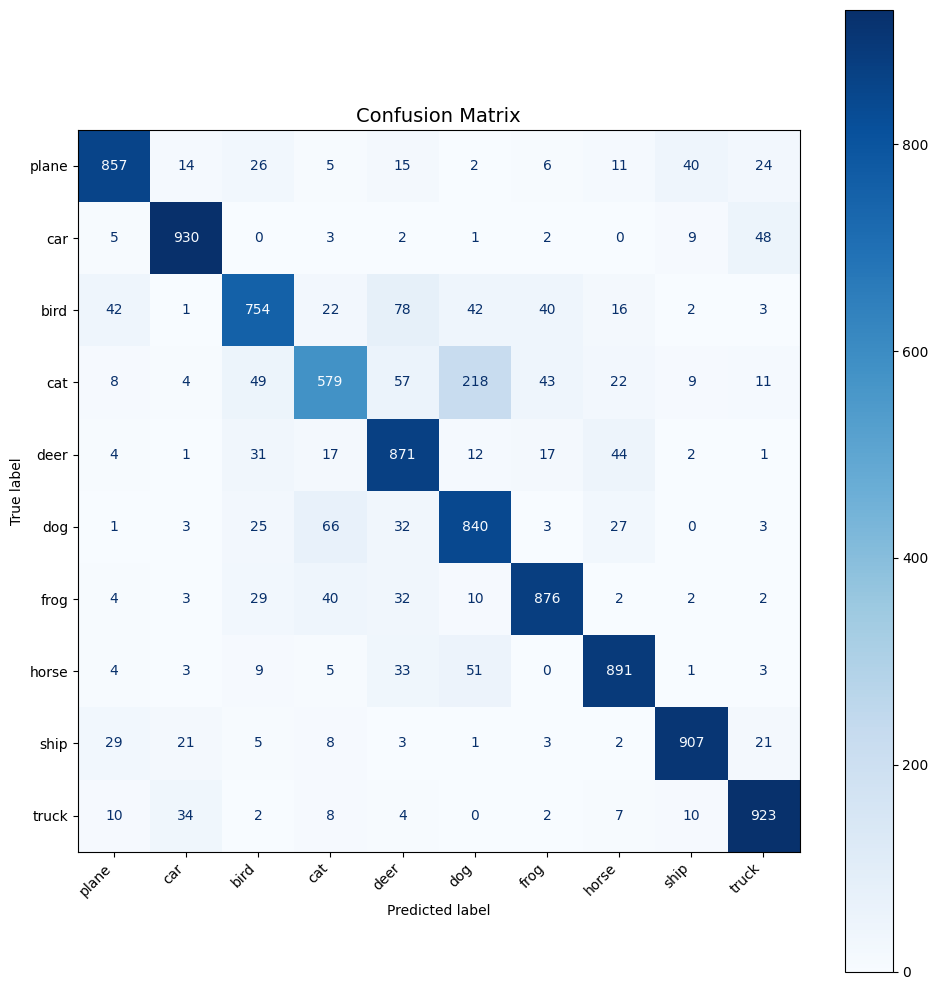

混淆矩阵已保存到 ./outputs/cifar/confusion_matrix_base_experiment.png
********************
Experiment base_experiment  Acc: 84.28%

############################################################
# 实验 2/7: add_hidden_dim
############################################################

训练配置: add_hidden_dim
L2正则化: 否
早停机制: 启用 (patience=10)

Epoch: 1/200 | Batch: 100/782 | Loss: 2.3030 | Train Acc: 9.81%
Epoch: 1/200 | Batch: 200/782 | Loss: 2.3026 | Train Acc: 10.02%
Epoch: 1/200 | Batch: 300/782 | Loss: 2.3026 | Train Acc: 10.14%
Epoch: 1/200 | Batch: 400/782 | Loss: 2.3027 | Train Acc: 10.08%
Epoch: 1/200 | Batch: 500/782 | Loss: 2.3027 | Train Acc: 10.00%
Epoch: 1/200 | Batch: 600/782 | Loss: 2.3027 | Train Acc: 9.98%
Epoch: 1/200 | Batch: 700/782 | Loss: 2.3027 | Train Acc: 10.07%

Epoch 1 完成 - 测试准确率: 10.00%
✓ 最佳模型已保存，准确率: 10.00%

Epoch: 2/200 | Batch: 100/782 | Loss: 2.3025 | Train Acc: 10.23%
Epoch: 2/200 | Batch: 200/782 | Loss: 2.3026 | Train Acc: 10.33%
Epoch: 2/200 | Batch: 300/782 | Loss: 2.

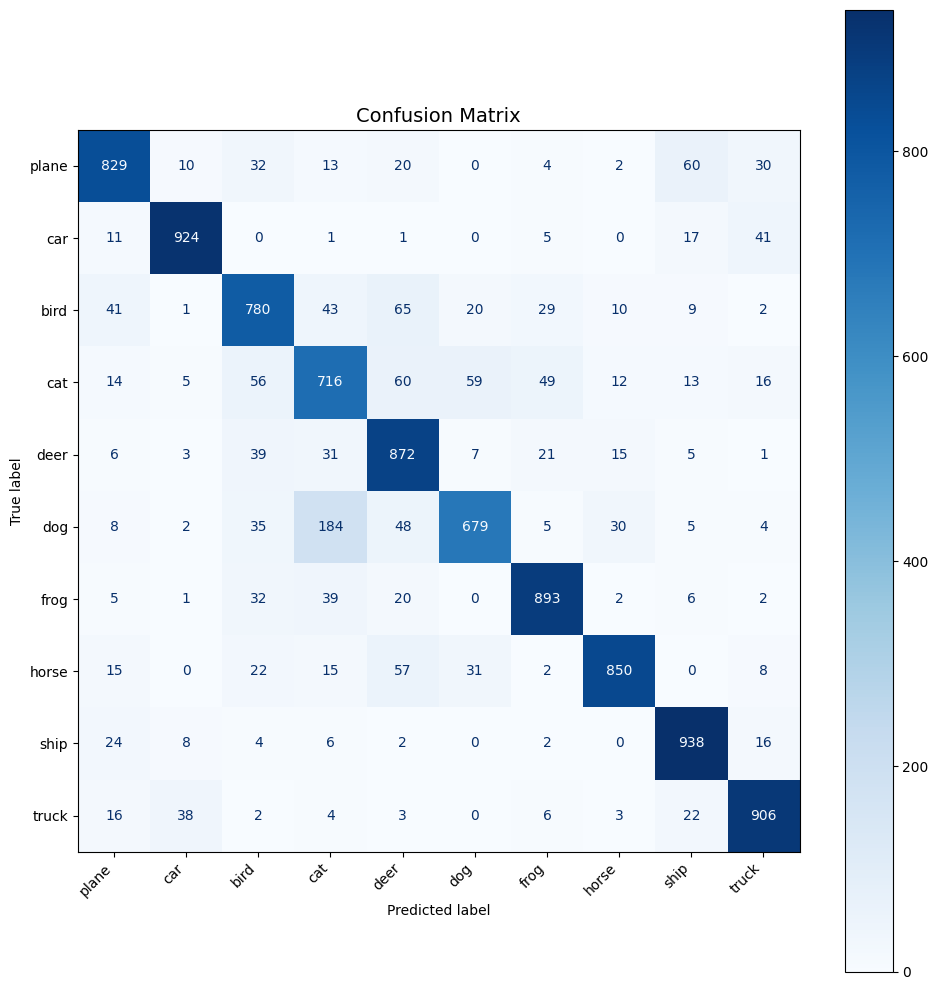

混淆矩阵已保存到 ./outputs/cifar/confusion_matrix_add_hidden_dim.png
********************
Experiment add_hidden_dim  Acc: 83.87%

############################################################
# 实验 3/7: add_layer_num
############################################################

训练配置: add_layer_num
L2正则化: 否
早停机制: 启用 (patience=10)

Epoch: 1/200 | Batch: 100/782 | Loss: 2.3036 | Train Acc: 9.98%
Epoch: 1/200 | Batch: 200/782 | Loss: 2.3027 | Train Acc: 10.25%
Epoch: 1/200 | Batch: 300/782 | Loss: 2.3044 | Train Acc: 9.99%
Epoch: 1/200 | Batch: 400/782 | Loss: 2.3034 | Train Acc: 9.92%
Epoch: 1/200 | Batch: 500/782 | Loss: 2.3035 | Train Acc: 9.79%
Epoch: 1/200 | Batch: 600/782 | Loss: 2.3032 | Train Acc: 9.85%
Epoch: 1/200 | Batch: 700/782 | Loss: 2.3025 | Train Acc: 9.89%

Epoch 1 完成 - 测试准确率: 10.00%
✓ 最佳模型已保存，准确率: 10.00%

Epoch: 2/200 | Batch: 100/782 | Loss: 2.3031 | Train Acc: 9.89%
Epoch: 2/200 | Batch: 200/782 | Loss: 2.3029 | Train Acc: 10.18%
Epoch: 2/200 | Batch: 300/782 | Loss: 2.3030 | Tr

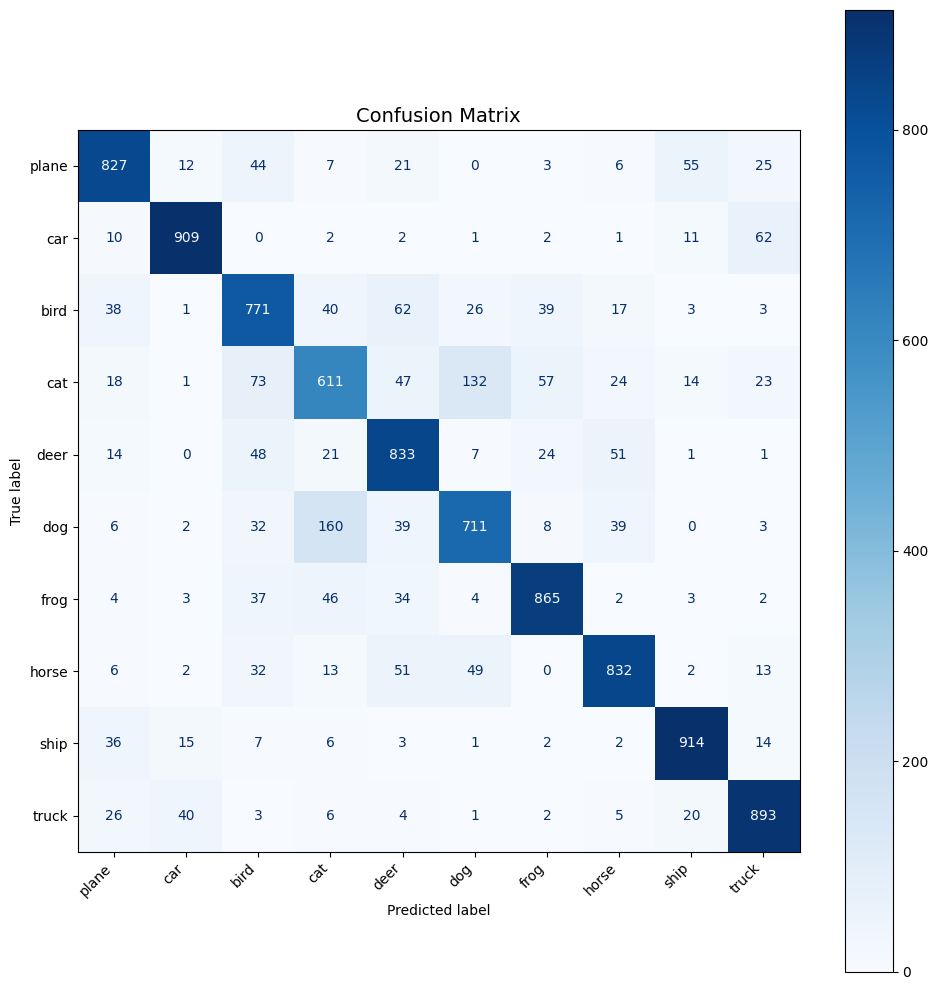

混淆矩阵已保存到 ./outputs/cifar/confusion_matrix_add_layer_num.png
********************
Experiment add_layer_num  Acc: 81.66%

############################################################
# 实验 4/7: use_mean_pooling
############################################################

训练配置: use_mean_pooling
L2正则化: 否
早停机制: 启用 (patience=10)

Epoch: 1/200 | Batch: 100/782 | Loss: 2.3054 | Train Acc: 9.59%
Epoch: 1/200 | Batch: 200/782 | Loss: 2.3044 | Train Acc: 9.78%
Epoch: 1/200 | Batch: 300/782 | Loss: 2.3046 | Train Acc: 9.78%
Epoch: 1/200 | Batch: 400/782 | Loss: 2.3034 | Train Acc: 9.84%
Epoch: 1/200 | Batch: 500/782 | Loss: 2.3029 | Train Acc: 9.84%
Epoch: 1/200 | Batch: 600/782 | Loss: 2.3021 | Train Acc: 10.02%
Epoch: 1/200 | Batch: 700/782 | Loss: 2.3039 | Train Acc: 9.96%

Epoch 1 完成 - 测试准确率: 10.00%
✓ 最佳模型已保存，准确率: 10.00%

Epoch: 2/200 | Batch: 100/782 | Loss: 2.3026 | Train Acc: 10.48%
Epoch: 2/200 | Batch: 200/782 | Loss: 2.3029 | Train Acc: 10.26%
Epoch: 2/200 | Batch: 300/782 | Loss: 2.3032

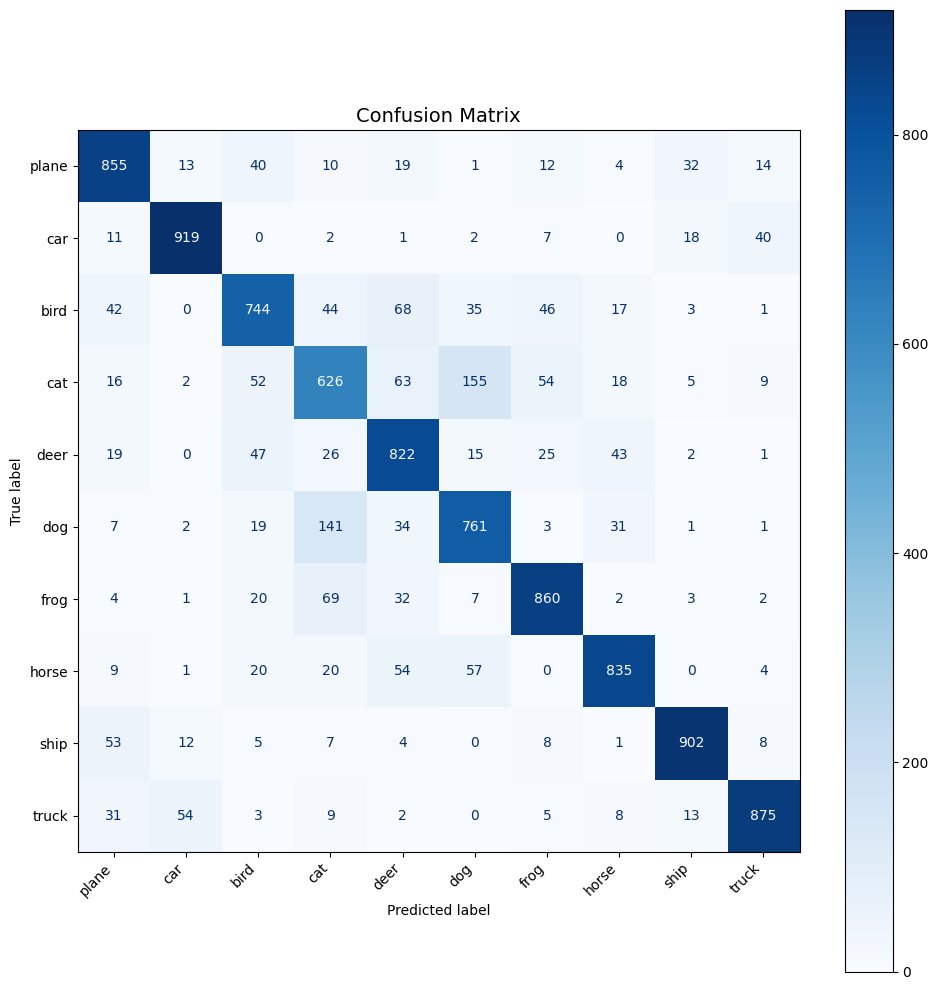

混淆矩阵已保存到 ./outputs/cifar/confusion_matrix_use_mean_pooling.png
********************
Experiment use_mean_pooling  Acc: 81.99%

############################################################
# 实验 5/7: use_resnet
############################################################

训练配置: use_resnet
L2正则化: 否
早停机制: 启用 (patience=10)

Epoch: 1/200 | Batch: 100/782 | Loss: 2.3082 | Train Acc: 10.44%
Epoch: 1/200 | Batch: 200/782 | Loss: 2.2589 | Train Acc: 13.12%
Epoch: 1/200 | Batch: 300/782 | Loss: 2.1382 | Train Acc: 14.99%
Epoch: 1/200 | Batch: 400/782 | Loss: 2.0015 | Train Acc: 16.45%
Epoch: 1/200 | Batch: 500/782 | Loss: 1.9005 | Train Acc: 17.97%
Epoch: 1/200 | Batch: 600/782 | Loss: 1.8594 | Train Acc: 19.23%
Epoch: 1/200 | Batch: 700/782 | Loss: 1.8002 | Train Acc: 20.34%

Epoch 1 完成 - 测试准确率: 27.71%
✓ 最佳模型已保存，准确率: 27.71%

Epoch: 2/200 | Batch: 100/782 | Loss: 1.7002 | Train Acc: 32.03%
Epoch: 2/200 | Batch: 200/782 | Loss: 1.6979 | Train Acc: 32.34%
Epoch: 2/200 | Batch: 300/782 | Loss: 1.6474

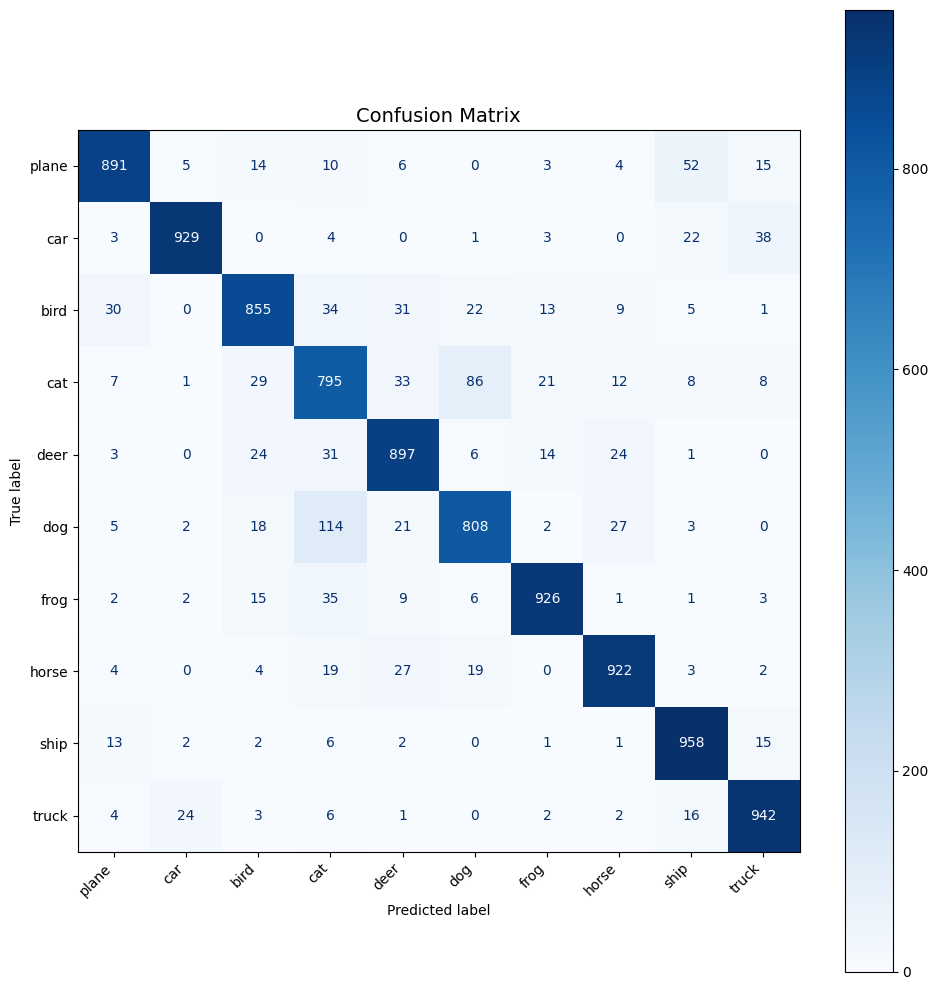

混淆矩阵已保存到 ./outputs/cifar/confusion_matrix_use_resnet.png
********************
Experiment use_resnet  Acc: 89.23%

############################################################
# 实验 6/7: use_l2_regular
############################################################

训练配置: use_l2_regular_l2reg
L2正则化: 是 (λ=0.001)
早停机制: 启用 (patience=10)

Epoch: 1/200 | Batch: 100/782 | Loss: 2.3899 | Train Acc: 9.45%
Epoch: 1/200 | Batch: 200/782 | Loss: 2.3884 | Train Acc: 10.09%
Epoch: 1/200 | Batch: 300/782 | Loss: 2.3897 | Train Acc: 10.05%
Epoch: 1/200 | Batch: 400/782 | Loss: 2.3886 | Train Acc: 10.05%
Epoch: 1/200 | Batch: 500/782 | Loss: 2.3886 | Train Acc: 9.97%
Epoch: 1/200 | Batch: 600/782 | Loss: 2.3875 | Train Acc: 10.05%
Epoch: 1/200 | Batch: 700/782 | Loss: 2.3882 | Train Acc: 10.02%

Epoch 1 完成 - 测试准确率: 10.00%
✓ 最佳模型已保存，准确率: 10.00%

Epoch: 2/200 | Batch: 100/782 | Loss: 2.3876 | Train Acc: 10.62%
Epoch: 2/200 | Batch: 200/782 | Loss: 2.3879 | Train Acc: 10.25%
Epoch: 2/200 | Batch: 300/782 | Lo

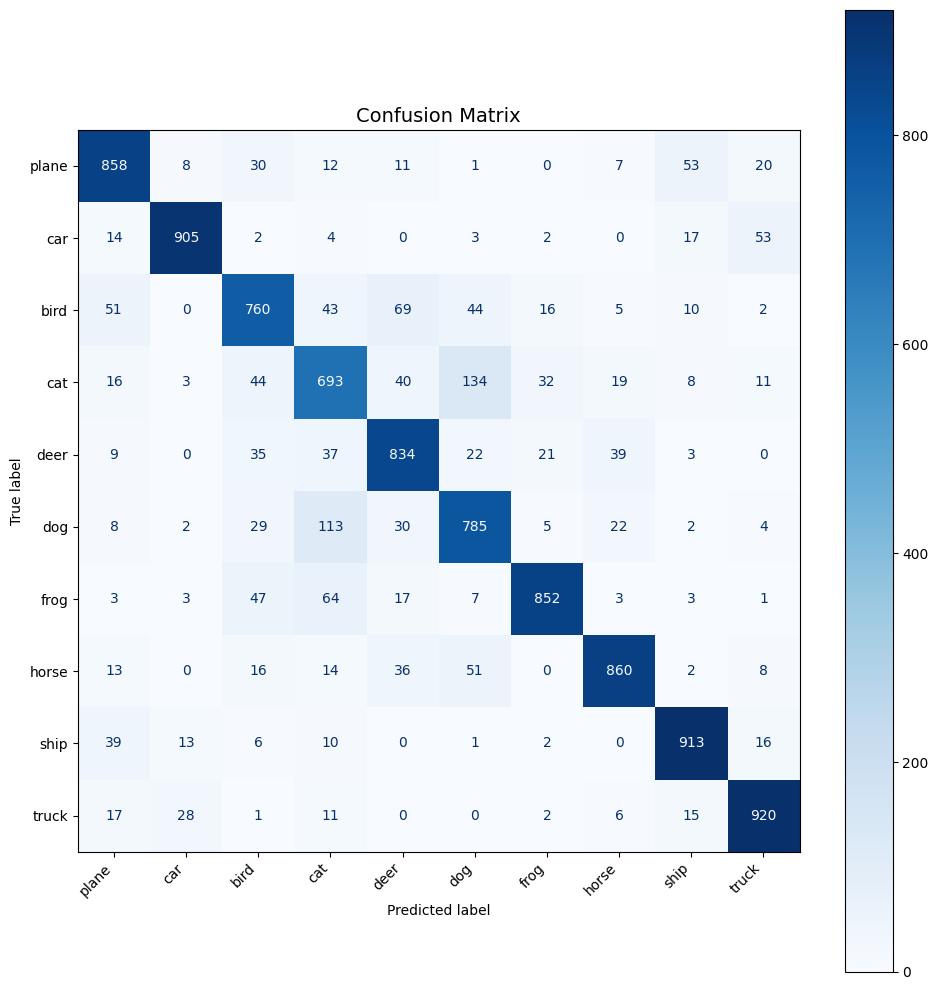

混淆矩阵已保存到 ./outputs/cifar/confusion_matrix_use_l2_regular_l2reg.png
********************
Experiment use_l2_regular  Acc: 83.80%

############################################################
# 实验 7/7: use_adam
############################################################

训练配置: use_adam
L2正则化: 否
早停机制: 启用 (patience=10)

Epoch: 1/200 | Batch: 100/782 | Loss: 2.2608 | Train Acc: 12.45%
Epoch: 1/200 | Batch: 200/782 | Loss: 2.0841 | Train Acc: 15.92%
Epoch: 1/200 | Batch: 300/782 | Loss: 1.9489 | Train Acc: 17.65%
Epoch: 1/200 | Batch: 400/782 | Loss: 1.8757 | Train Acc: 19.70%
Epoch: 1/200 | Batch: 500/782 | Loss: 1.8042 | Train Acc: 21.71%
Epoch: 1/200 | Batch: 600/782 | Loss: 1.7738 | Train Acc: 23.18%
Epoch: 1/200 | Batch: 700/782 | Loss: 1.7077 | Train Acc: 24.70%

Epoch 1 完成 - 测试准确率: 39.08%
✓ 最佳模型已保存，准确率: 39.08%

Epoch: 2/200 | Batch: 100/782 | Loss: 1.5998 | Train Acc: 39.67%
Epoch: 2/200 | Batch: 200/782 | Loss: 1.6007 | Train Acc: 39.32%
Epoch: 2/200 | Batch: 300/782 | Loss: 1.5762 |

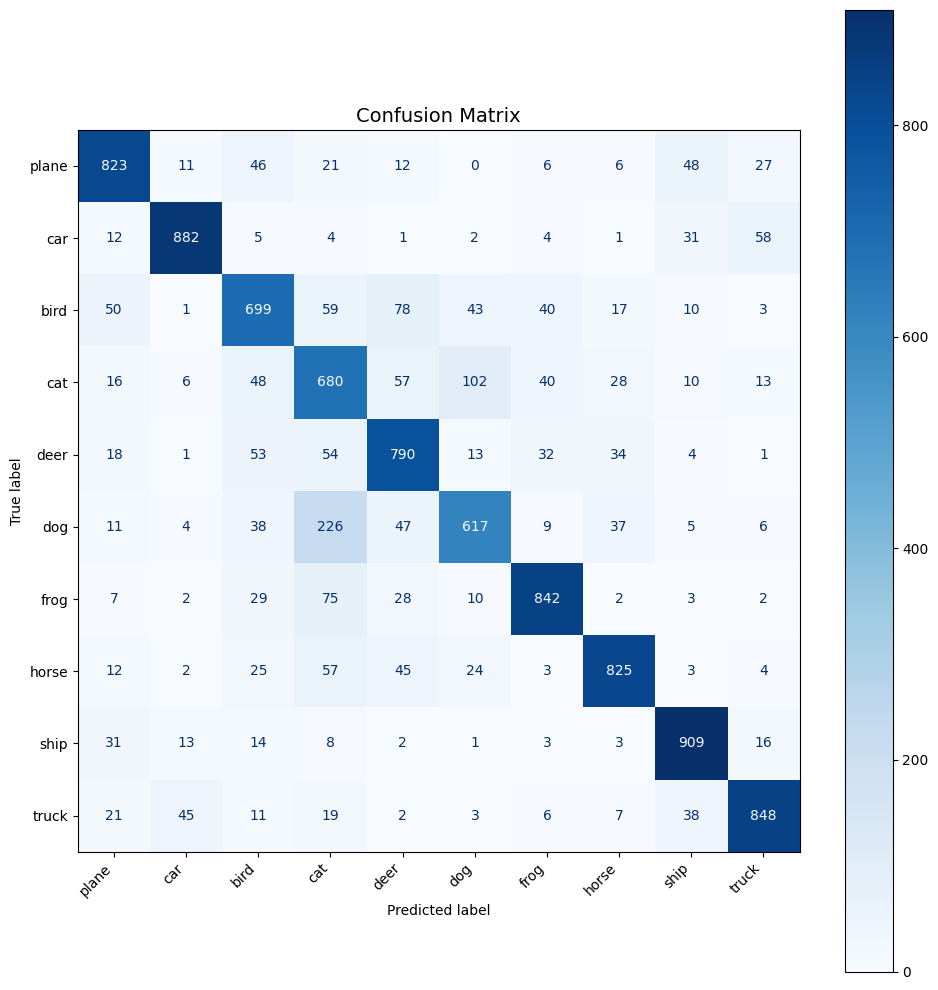

混淆矩阵已保存到 ./outputs/cifar/confusion_matrix_use_adam.png
********************
Experiment use_adam  Acc: 79.15%


In [48]:
# 运行实验
results = {}

for i, exp in enumerate(experiments):
    print(f"\n{'#'*60}")
    print(f"# 实验 {i+1}/{len(experiments)}: {exp['name']}")
    print(f"{'#'*60}")
    
    # 创建模型
    model = CNNBase(
        is_large_layer=exp['args'].get('is_large_layer', False),
        is_large_hidden=exp['args'].get('is_large_hidden', False),
        pooling_type=exp['args'].get('mean_pooling', False),
        is_resnet=exp['args'].get('is_resnet', False),
        label_num=10
    ).to(device)
    
    # 损失函数和优化器
    criterion = nn.CrossEntropyLoss()
    if exp['args'].get('use_adam', False):
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    else:
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    
    config_name = exp['name']
    if exp['args'].get('is_l2_loss', False):
        config_name += "_l2reg"
    
    # 训练模型
    start_time = time.time()
    accuracies, best_acc = train(
        model, train_loader, test_loader, criterion, optimizer,
        epochs=num_epochs, device=device, save_dir=save_dir,
        is_l2_loss=exp['args'].get('is_l2_loss', False),
        l2_lambda=0.001,
        config_name=config_name
    )
    training_time = time.time() - start_time
    
    # 详细测试
    y_trues, y_preds, final_acc = detailed_test(model, test_loader, device, classes, save_path=os.path.join(save_dir, f'best_{config_name}.pth'))
    
    # 保存混淆矩阵
    cm_path = f'./outputs/cifar/confusion_matrix_{config_name}.png'
    plot_confusion_matrix(y_trues, y_preds, classes, cm_path)
    
    # 记录结果
    results[exp['name']] = {
        'accuracies': accuracies,
        'best_acc': best_acc,
        'final_acc': final_acc,
        'training_time': training_time
    }
    
    print('*'*20)
    print(f"Experiment {exp['name']}  Acc: {final_acc:.2f}%")
    
    # 保存结果到文件
    with open('./outputs/cifar/experiment_results.txt', 'a') as f:
        f.write(f"Experiment: {exp['name']}, Final Accuracy: {final_acc:.2f}%, Training Time: {training_time:.2f} seconds\n")


## 结果分析和可视化


/tmp/ipykernel_3946303/37132536.py:27: UserWarning: Glyph 19981 (\N{CJK UNIFIED IDEOGRAPH-4E0D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3946303/37132536.py:27: UserWarning: Glyph 21516 (\N{CJK UNIFIED IDEOGRAPH-540C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3946303/37132536.py:27: UserWarning: Glyph 37197 (\N{CJK UNIFIED IDEOGRAPH-914D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3946303/37132536.py:27: UserWarning: Glyph 32622 (\N{CJK UNIFIED IDEOGRAPH-7F6E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3946303/37132536.py:27: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3946303/37132536.py:27: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3946303/37132536.py:27: UserWarning: Glyph 35797 (\N{CJK UNIFIED IDEOGRAP

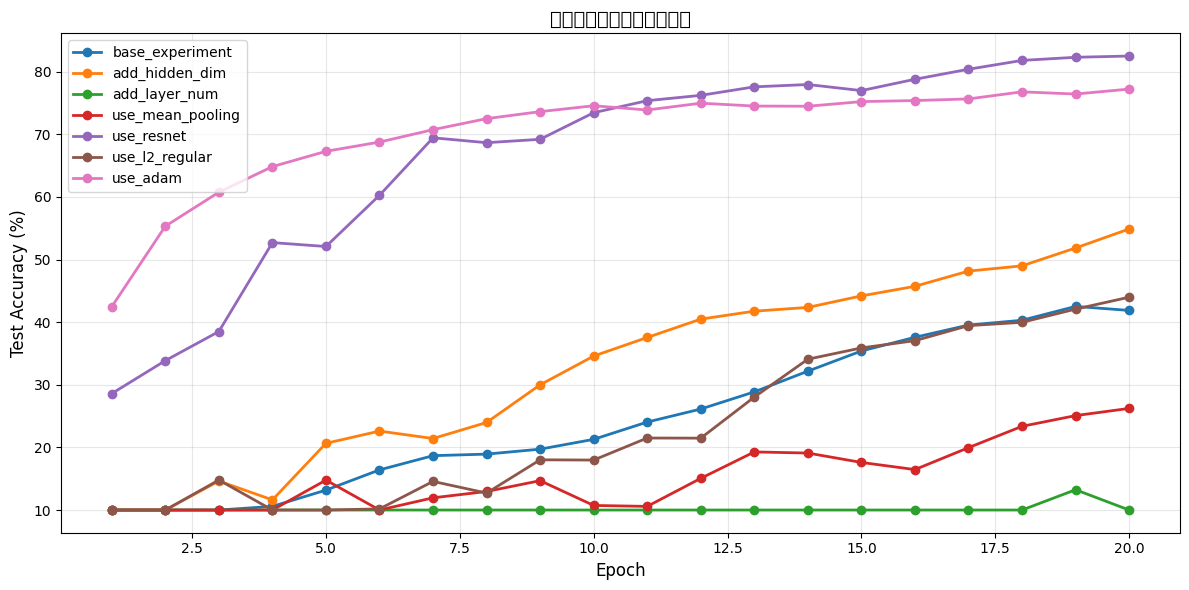

训练历史图已保存到 ./outputs/cifar/training_history_comparison.png

实验结果汇总
实验名称                 最终准确率        最佳准确率        训练时间(秒)        
--------------------------------------------------------------------------------
base_experiment      41.88        42.52        108.38         
add_hidden_dim       54.89        54.89        166.22         
add_layer_num        10.00        13.24        119.09         
use_mean_pooling     26.23        26.23        108.51         
use_resnet           82.51        82.51        178.97         
use_l2_regular       43.99        43.99        126.20         
use_adam             77.23        77.23        110.61         

最佳配置: use_resnet (准确率: 82.51%)


In [ ]:
# 绘制训练历史比较图
history_dict = {name: data['accuracies'] for name, data in results.items()}
plot_training_history(history_dict, './outputs/cifar/training_history_comparison.png')

# 创建结果汇总表
print("\n" + "="*80)
print("实验结果汇总")
print("="*80)
print(f"{'实验名称':<20} {'最终准确率':<12} {'最佳准确率':<12} {'训练时间(秒)':<15}")
print("-"*80)

for name, data in results.items():
    print(f"{name:<20} {data['final_acc']:<12.2f} {data['best_acc']:<12.2f} {data['training_time']:<15.2f}")

# 找出最佳配置
best_exp = max(results.items(), key=lambda x: x[1]['final_acc'])
print(f"\n最佳配置: {best_exp[0]} (准确率: {best_exp[1]['final_acc']:.2f}%)")
